In [ ]:
!pip install torch pandas transformers scikit-learn
!pip install datasets
!pip install matplotlib
!pip install accelerate -U
!pip install transformers[torch]
# Dogshit accelerate check
!pip install accelerate
!pip install seaborn
import accelerate
print(accelerate.__version__)

In [14]:
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from torch import tensor
from transformers import ElectraTokenizer,ElectraModel, ElectraForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import os

data = pd.read_csv('./editedlabels.csv',index_col=0)

In [15]:
data

,org_label,text,label
0,0,co se děje,2
1,n,"Jsem z nich na prášky...:-D :D ... se divím , ...",0
2,p,Nejlepší bylo Bounty... :-),1
3,0,:D Já jsem četla: z vlaku vypadl kluk Ruda :D,2
4,0,a budou venku i v neděly?=O],2
...,...,...,...
8747,0,ne al chtěla bych,2
8748,n,"vidim že O2 řeší problemy tím, že smaže diskus...",0
8749,0,ale koupili jsme ! :P,2
8750,0,"Dobrý den, tel. číslo je 723 735 749. Děkuji",2


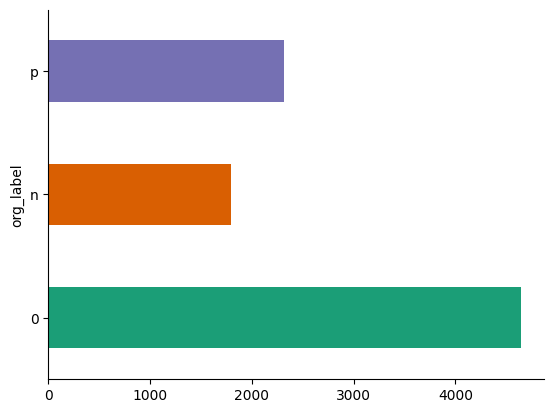

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('org_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
train_data, val_data = train_test_split(data, test_size=0.3)
model_path="./model"

print(f"Validation size : {len(val_data)}\nTrain size : {len(train_data)}")

train_raw = Dataset.from_pandas(train_data)
test_raw = Dataset.from_pandas(val_data)

tokenizer = ElectraTokenizer.from_pretrained(model_path)

def preprocess_function(examples):
    encoded_inputs = tokenizer(examples['text'], padding="max_length", truncation=True,max_length=64)
    input_ids = encoded_inputs.input_ids
    attention_mask = encoded_inputs.attention_mask
    labels = examples['label']
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# tokenize them to make it ready
train_processed = train_raw.map(preprocess_function, batched=True)
test_processed = test_raw.map(preprocess_function, batched=True)


from transformers import DataCollatorWithPadding

# also we will use that for training
# It will convert the training samples to PyTorch tensors and concatenate them with the correct amount of padding
# Ex : https://huggingface.co/blog/sentiment-analysis-python
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Validation size : 2626
Train size : 6126


Map:   0%|          | 0/6126 [00:00<?, ? examples/s]

Map:   0%|          | 0/2626 [00:00<?, ? examples/s]

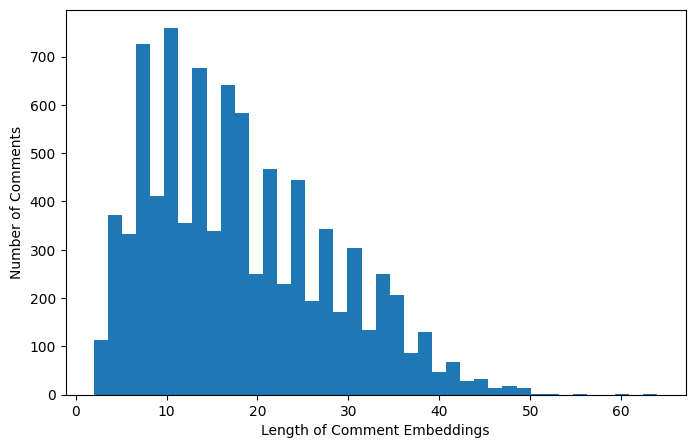

In [18]:
# max length defined as 64

import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

plot_sentence_embeddings_length(data.text, tokenizer)

# Which tells us that max 64 is quite ok

In [34]:
import numpy as np
from datasets import load_metric

# metrics for f1 score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = load_metric("accuracy")
    f1 = load_metric("f1")

    # Compute accuracy and F1 score using appropriate averages for multiclass
    results = {
        'accuracy': accuracy.compute(predictions=predictions, references=labels)['accuracy'],
        # 'f1': f1.compute(predictions=predictions, references=labels, average=None)['f1'],
        'f1_macro': f1.compute(predictions=predictions, references=labels, average='macro')['f1'],
        'f1_weighted': f1.compute(predictions=predictions, references=labels, average='weighted')['f1']
    }
    return results

In [35]:
model = ElectraForSequenceClassification.from_pretrained(model_path,num_labels=3) # 3 layers for positive negative neutral

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at ./model and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(early_stopping_patience=50)
# Lets check cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

repo_name = "electra-czech-fb-comment-3"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=1e-4,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=64,
   warmup_steps=500,
   num_train_epochs=16,
   weight_decay=0.01,
   save_strategy="epoch",
   evaluation_strategy="epoch",
   load_best_model_at_end=True
  #  push_to_hub=True, # I will push it later
)

trainer = Trainer(
   model=model.to(device), # moved to gpu
   args=training_args,
   train_dataset=train_processed,
   eval_dataset=test_processed,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
   callbacks=[early_stopping],
)


Using device: cuda


/home/alienware/.local/lib/python3.10/site-packages/accelerate/accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [25]:
data['label'].value_counts()

label
2    4642
1    2318
0    1792
Name: count, dtype: int64

In [38]:
trainer.train()

  0%|          | 0/6128 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 0.6927724480628967, 'eval_accuracy': 0.7071591774562072, 'eval_f1_macro': 0.6782062844706663, 'eval_f1_weighted': 0.7042213842365379, 'eval_runtime': 2.3162, 'eval_samples_per_second': 1133.763, 'eval_steps_per_second': 18.133, 'epoch': 1.0}
{'loss': 0.8822, 'learning_rate': 0.0001, 'epoch': 1.31}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 0.5821981430053711, 'eval_accuracy': 0.7665651180502666, 'eval_f1_macro': 0.7282807175108674, 'eval_f1_weighted': 0.757923736246138, 'eval_runtime': 2.362, 'eval_samples_per_second': 1111.762, 'eval_steps_per_second': 17.781, 'epoch': 2.0}
{'loss': 0.5356, 'learning_rate': 9.111584932480456e-05, 'epoch': 2.61}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 0.651833176612854, 'eval_accuracy': 0.7795125666412795, 'eval_f1_macro': 0.739728698521486, 'eval_f1_weighted': 0.7700743425681361, 'eval_runtime': 2.295, 'eval_samples_per_second': 1144.239, 'eval_steps_per_second': 18.301, 'epoch': 3.0}
{'loss': 0.318, 'learning_rate': 8.22316986496091e-05, 'epoch': 3.92}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 0.8065508008003235, 'eval_accuracy': 0.7399086062452399, 'eval_f1_macro': 0.7274015017422832, 'eval_f1_weighted': 0.7414675390451884, 'eval_runtime': 2.2941, 'eval_samples_per_second': 1144.692, 'eval_steps_per_second': 18.308, 'epoch': 4.0}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 0.9394689202308655, 'eval_accuracy': 0.7764661081492764, 'eval_f1_macro': 0.7451832450246402, 'eval_f1_weighted': 0.7709325825286166, 'eval_runtime': 2.42, 'eval_samples_per_second': 1085.135, 'eval_steps_per_second': 17.356, 'epoch': 5.0}
{'loss': 0.2004, 'learning_rate': 7.334754797441365e-05, 'epoch': 5.22}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 1.1877597570419312, 'eval_accuracy': 0.7692307692307693, 'eval_f1_macro': 0.7430977261250594, 'eval_f1_weighted': 0.7657768353533327, 'eval_runtime': 2.3023, 'eval_samples_per_second': 1140.603, 'eval_steps_per_second': 18.243, 'epoch': 6.0}
{'loss': 0.1313, 'learning_rate': 6.446339729921819e-05, 'epoch': 6.53}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 1.3777751922607422, 'eval_accuracy': 0.7627570449352628, 'eval_f1_macro': 0.7362353604235778, 'eval_f1_weighted': 0.7588169174003457, 'eval_runtime': 2.3324, 'eval_samples_per_second': 1125.883, 'eval_steps_per_second': 18.007, 'epoch': 7.0}
{'loss': 0.0913, 'learning_rate': 5.557924662402275e-05, 'epoch': 7.83}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 1.379567265510559, 'eval_accuracy': 0.7806549885757806, 'eval_f1_macro': 0.7529427506404982, 'eval_f1_weighted': 0.7769499701189988, 'eval_runtime': 2.3336, 'eval_samples_per_second': 1125.29, 'eval_steps_per_second': 17.998, 'epoch': 8.0}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 1.5086027383804321, 'eval_accuracy': 0.7821782178217822, 'eval_f1_macro': 0.7500625106441193, 'eval_f1_weighted': 0.7762423670050885, 'eval_runtime': 2.3548, 'eval_samples_per_second': 1115.158, 'eval_steps_per_second': 17.836, 'epoch': 9.0}
{'loss': 0.0582, 'learning_rate': 4.669509594882729e-05, 'epoch': 9.14}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 1.5707954168319702, 'eval_accuracy': 0.7688499619192688, 'eval_f1_macro': 0.749687938070737, 'eval_f1_weighted': 0.7701306708927342, 'eval_runtime': 2.281, 'eval_samples_per_second': 1151.243, 'eval_steps_per_second': 18.413, 'epoch': 10.0}
{'loss': 0.0506, 'learning_rate': 3.781094527363184e-05, 'epoch': 10.44}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 1.5683690309524536, 'eval_accuracy': 0.7852246763137852, 'eval_f1_macro': 0.7596630530926838, 'eval_f1_weighted': 0.7816255035886407, 'eval_runtime': 2.3007, 'eval_samples_per_second': 1141.402, 'eval_steps_per_second': 18.255, 'epoch': 11.0}
{'loss': 0.0367, 'learning_rate': 2.892679459843639e-05, 'epoch': 11.75}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 1.6249873638153076, 'eval_accuracy': 0.7833206397562833, 'eval_f1_macro': 0.7585577747592254, 'eval_f1_weighted': 0.7802266393173926, 'eval_runtime': 2.6822, 'eval_samples_per_second': 979.042, 'eval_steps_per_second': 15.659, 'epoch': 12.0}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 1.685062289237976, 'eval_accuracy': 0.7795125666412795, 'eval_f1_macro': 0.75746016791229, 'eval_f1_weighted': 0.7783518418754866, 'eval_runtime': 2.3578, 'eval_samples_per_second': 1113.77, 'eval_steps_per_second': 17.814, 'epoch': 13.0}
{'loss': 0.0224, 'learning_rate': 2.004264392324094e-05, 'epoch': 13.05}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 1.7253159284591675, 'eval_accuracy': 0.7734196496572734, 'eval_f1_macro': 0.7500234302252641, 'eval_f1_weighted': 0.7709727361172158, 'eval_runtime': 2.2957, 'eval_samples_per_second': 1143.897, 'eval_steps_per_second': 18.295, 'epoch': 14.0}
{'loss': 0.0192, 'learning_rate': 1.1158493248045487e-05, 'epoch': 14.36}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 1.751253604888916, 'eval_accuracy': 0.7734196496572734, 'eval_f1_macro': 0.7519537145401637, 'eval_f1_weighted': 0.7722069702178419, 'eval_runtime': 2.3293, 'eval_samples_per_second': 1127.376, 'eval_steps_per_second': 18.031, 'epoch': 15.0}
{'loss': 0.0162, 'learning_rate': 2.2743425728500355e-06, 'epoch': 15.67}


  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

{'eval_loss': 1.7589869499206543, 'eval_accuracy': 0.7738004569687738, 'eval_f1_macro': 0.7521038268528019, 'eval_f1_weighted': 0.772267257338616, 'eval_runtime': 2.3661, 'eval_samples_per_second': 1109.856, 'eval_steps_per_second': 17.751, 'epoch': 16.0}
{'train_runtime': 220.6153, 'train_samples_per_second': 444.285, 'train_steps_per_second': 27.777, 'train_loss': 0.1928782812647969, 'epoch': 16.0}


TrainOutput(global_step=6128, training_loss=0.1928782812647969, metrics={'train_runtime': 220.6153, 'train_samples_per_second': 444.285, 'train_steps_per_second': 27.777, 'train_loss': 0.1928782812647969, 'epoch': 16.0})

In [39]:
eval_results = trainer.evaluate()

  0%|          | 0/42 [00:00<?, ?it/s]

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

In [40]:
print(eval_results)

{'eval_loss': 0.5821981430053711, 'eval_accuracy': 0.7665651180502666, 'eval_f1_macro': 0.7282807175108674, 'eval_f1_weighted': 0.757923736246138, 'eval_runtime': 2.3672, 'eval_samples_per_second': 1109.334, 'eval_steps_per_second': 17.743, 'epoch': 16.0}


In [41]:
def predict_by_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=64)
    # Move the tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make prediction
    with torch.no_grad():
        logits = model(**inputs).logits  # Adjust if your model output structure is different

    # Convert logits to probabilities using softmax
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1)
    class_labels = {0: "Negative", 1: "Positive", 2: "Neutral"}  # Adjust accordingly

    # Convert predicted class ID to label
    predicted_label = class_labels[predicted_class.item()]

    return predicted_label, predicted_class


In [32]:
data

,org_label,text,label
0,0,co se děje,2
1,n,"Jsem z nich na prášky...:-D :D ... se divím , ...",0
2,p,Nejlepší bylo Bounty... :-),1
3,0,:D Já jsem četla: z vlaku vypadl kluk Ruda :D,2
4,0,a budou venku i v neděly?=O],2
...,...,...,...
8747,0,ne al chtěla bych,2
8748,n,"vidim že O2 řeší problemy tím, že smaže diskus...",0
8749,0,ale koupili jsme ! :P,2
8750,0,"Dobrý den, tel. číslo je 723 735 749. Děkuji",2


In [56]:
predict_by_text('Měsíčně máte 125 + 125, že. To stojí kolik ?')

('Neutral', tensor([2], device='cuda:0'))

In [58]:
# Model config settings
# model.config
id2label = {0: "NEGATIVE", 1: "POSITIVE", 2: "NEUTRAL"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1, "NEUTRAL": 2}


model.config.id2label = id2label
model.config.label2id = label2id

In [59]:
model.config

ElectraConfig {
  "_name_or_path": "./model",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE",
    "2": "NEUTRAL"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "NEGATIVE": 0,
    "NEUTRAL": 2,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.36.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


In [60]:
model.save_pretrained("./sixteen_epoch")

In [ ]:
# # We will use this to see how big are the embeggings to use max length accordingly

# import matplotlib.pyplot as plt
# def plot_sentence_embeddings_length(text_list, tokenizer):
#     tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
#     tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
#     fig, ax = plt.subplots(figsize=(8, 5));
#     ax.hist(tokenized_texts_len, bins=40);
#     ax.set_xlabel("Length of Comment Embeddings");
#     ax.set_ylabel("Number of Comments");
#     return

# plot_sentence_embeddings_length(data.text, tokenizer)

# # Which tells us that max 64 is quite ok

In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel

# {'n': 0, 'p': 1, '0': 2}

id2label = {0: "NEGATIVE", 1: "POSITIVE", 2: "NEUTRAL"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1, "NEUTRAL": 2}

model_directory = "./lowest_loss"
model_loaded = AutoModelForSequenceClassification.from_pretrained(model_directory,num_labels=3, id2label=id2label, label2id=label2id)
tokenizer_loaded = AutoTokenizer.from_pretrained("./model")

In [3]:
model_loaded.config.id2label = id2label
model_loaded.config.label2id = label2id

In [6]:
# commented when whole ipynb file is run
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_loaded.to(device)

Using device: cuda


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [8]:
# i forgot to edit id2label , label2id part . I will skip that for now
model_loaded.config

ElectraConfig {
  "_name_or_path": "./lowest_loss",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE",
    "2": "NEUTRAL"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "NEGATIVE": 0,
    "NEUTRAL": 2,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.36.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 

In [11]:
# test loaded model
def test_loaded_model(text,model):
    inputs = tokenizer_loaded(text, return_tensors="pt")
    inputs.to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        return model.config.id2label[predicted_class_id]

In [12]:
# labbel2id manual

labelsformodel = {
    "LABEL_0": "Negative",
    "LABEL_1": "Positive",
    "LABEL_2": "Neutral"
}

# labelsformodel[test_loaded_model("díky :-)I Vám :-)")]
test_loaded_model("díky :-)I Vám :-)",model_loaded)

'POSITIVE'

In [61]:
import huggingface_hub
huggingface_hub.notebook_login()

In [62]:
model.push_to_hub("tochkamg/electra-sequence-classifier-czech",use_auth_token=True,commit_message="commnt analyzer",private=False)

/home/alienware/.local/lib/python3.10/site-packages/transformers/utils/hub.py:821: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tochkamg/electra-sequence-classifier-czech/commit/3081bc8d7766cbf44de2ce748aedcd777744f725', commit_message='commnt analyzer', commit_description='', oid='3081bc8d7766cbf44de2ce748aedcd777744f725', pr_url=None, pr_revision=None, pr_num=None)

resources


https://huggingface.co/docs/transformers/en/tasks/sequence_classification
https://huggingface.co/blog/sentiment-analysis-python
https://www.kaggle.com/code/pavan9065/nlp-disaster-tweets-with-electra-base